In [1]:
import rioxarray
from matplotlib.ticker import MaxNLocator
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import os
import yaml
from pathlib import Path
import glob
import sys
base_dir = Path(os.path.dirname(os.path.realpath("__file__"))).parent.parent
import xarray as xr

# Load geom

[ 475794.60598328 5253918.44633978  476674.55017352 5255627.94596953]


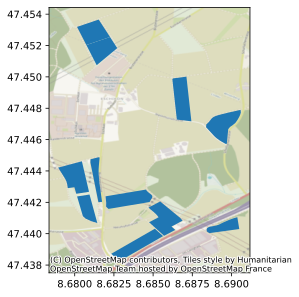

In [2]:
# Get data around SwissFutureFarm

shp = '../../data/Strickhof.shp'
gdf = gpd.read_file(shp)

plt.style.use('default')
fig, ax = plt.subplots()
gdf.plot(ax=ax)
cx.add_basemap(ax, crs=gdf.crs)

bounds = gdf.to_crs(32632).total_bounds
print(bounds)

# Load corresponding S2

In [3]:
# Find paths of data that falls in bounds

data_path = os.path.expanduser('~/mnt/eo-nas1/data/satellite/sentinel2/raw/CH/')
data_files = [f for f in os.listdir(data_path) if f.endswith('zarr')]
df_zarr = pd.DataFrame(data_files, columns=['file'])

def extract_minx_maxy(file):
    parts = file.split('_')
    minx = int(parts[1])
    maxy = int(parts[2])
    maxx = minx + 1280
    miny = maxy - 1280
    return minx, miny, maxx, maxy

# Apply the function to extract minx and maxy into new columns
df_zarr[['minx', 'miny', 'maxx', 'maxy']] = df_zarr['file'].apply(lambda x: pd.Series(extract_minx_maxy(x)))

In [ ]:
# Filter for location

df_farm = df_zarr[
    (df_zarr['maxx'] >= bounds[0]) &  # The box's maxx should be greater than or equal to bbox's minx
    (df_zarr['minx'] <= bounds[2]) &  # The box's minx should be less than or equal to bbox's maxx
    (df_zarr['maxy'] >= bounds[1]) &  # The box's maxy should be greater than or equal to bbox's miny
    (df_zarr['miny'] <= bounds[3])    # The box's miny should be less than or equal to bbox's maxy
]

In [ ]:
# Merge together: drop duplciate dates in each file

ds_list = [xr.open_zarr(os.path.join(data_path, f)).drop_duplicates(dim='time', keep='first') for f in df_farm.file.tolist()]
ds = xr.combine_by_coords(ds_list, combine_attrs='drop')

In [ ]:
# Clean data


def has_all_65535(ds):
    return ((ds == 65535).all(dim=['lat', 'lon'])).to_array().sum()

def has_clouds(ds, cloud_thresh=0.1):
    cloud_condition = (ds.s2_mask == 1) & (ds.s2_SCL.isin([8, 9, 10]))
    return cloud_condition.sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > cloud_thresh

def has_shadows(ds, shadow_thresh=0.1):
    shadow_condition = (ds.s2_mask == 2) & (ds.s2_SCL == 3)
    return shadow_condition.sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > shadow_thresh

def has_snow(ds, snow_thresh=0.1):
    snow_condition = (ds.s2_mask == 3) & (ds.s2_SCL == 11)
    return snow_condition.sum(dim=['lat', 'lon'])/(len(ds.lat)*len(ds.lon)) > snow_thresh

def has_cirrus(ds, cirrus_thresh=1000):
    cirrus_mask = ds.s2_SCL == 10
    cirrus_b02_mean = ds.s2_B02.where(cirrus_mask).mean(dim=['lat', 'lon'])
    return cirrus_b02_mean > cirrus_thresh

def clean_dataset(ds, cloud_thresh=0.1, shadow_thresh=0.1, snow_thresh=0.1, cirrus_thresh=1000):
  """
  Drop dates with no data and clouds/snow/shadows
  """
  n_times = len(ds.time)

  # Remove cloudy or missing dates: any of the bands is all 65535
  dates_to_drop = [i for i, date in enumerate(ds.time.values) if has_all_65535(ds.isel(time=i))]
  mask_dates = np.ones(len(ds.time), dtype=bool)
  mask_dates[dates_to_drop] = False
  ds = ds.isel(time=mask_dates)

  # Remove too many clouds (mask=1), shadows (mask=2) or snow (mask=3)
  dates_to_drop = [i for i, date in enumerate(ds.time.values) if has_clouds(ds.isel(time=i), cloud_thresh)] + \
                [i for i, date in enumerate(ds.time.values) if has_shadows(ds.isel(time=i), shadow_thresh)] + \
                [i for i, date in enumerate(ds.time.values) if has_snow(ds.isel(time=i), snow_thresh)] +\
                [i for i, date in enumerate(ds.time.values) if has_cirrus(ds.isel(time=i), cirrus_thresh)]
  mask_dates = np.ones(len(ds.time), dtype=bool)
  print(f'Dropping {len(set(dates_to_drop))}/{n_times} dates') # flag if too many dates dropped?
  mask_dates[dates_to_drop] = False
  ds = ds.isel(time=mask_dates)

  return ds

In [ ]:
testc i wan t to see weterj tjos wo
this is a speed writign test and i want to see how long it takes me to type woth only a l,ited a,outn fo akdkfjskdjflskjf